In [58]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

import lime
import lime.lime_tabular
import shap

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [6]:
df = pd.read_csv("NSL_KDD/KDDTrain+.txt")

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

df.columns = columns
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125972.0,287.146929,2.604526e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125972.0,45567.100824,5.870354e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125972.0,19779.271433,4.021285e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125972.0,0.000198,1.408613e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125972.0,0.022688,2.535310e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125972.0,0.000111,1.436608e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125972.0,0.204411,2.149977e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125972.0,0.001222,4.523932e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125972.0,0.395739,4.890107e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125972.0,0.279253,2.394214e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [9]:
df = df.drop('level', axis=1)

In [10]:
# changing attack labels to their respective attack class
def change_label(df):
    df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
    df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [11]:
change_label(df)
df.attack.unique()

array(['normal', 'Dos', 'R2L', 'Probe', 'U2R'], dtype=object)

In [12]:
df.attack.value_counts()

attack
normal    67342
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

In [13]:
fig = go.Figure(data=[
    go.Bar(name='normal', 
        y=df["attack"].value_counts().values[0:1],
        x=['normal'],
        text = df["attack"].value_counts()[0:1],
        orientation='v',
        textposition='outside',),
    go.Bar(name='Dos', 
        y=df["attack"].value_counts().values[1:2],
        x=['Dos'],
        text = df["attack"].value_counts()[1:2],
        orientation='v',
        textposition='outside',),
    go.Bar(name='Probe', 
        y=df["attack"].value_counts().values[2:3],
        x=['Probe'],
        text = df["attack"].value_counts()[2:3],
        orientation='v',
        textposition='outside',),
    go.Bar(name='R2L', 
        y=df["attack"].value_counts().values[3:4],
        x=['R2L'],
        text = df["attack"].value_counts()[3:4],
        orientation='v',
        textposition='outside',),
    go.Bar(name='U2R', 
        y=df["attack"].value_counts().values[4:5],
        x=['U2R'],
        text = df["attack"].value_counts()[4:5],
        orientation='v',
        textposition='outside',),
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Attack Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Class',)
iplot(fig)


In [15]:
# Step 2: Extract TCP flows
tcp_flows = df[df['protocol_type'] == 'tcp']

In [16]:
tcp_flows.attack.value_counts()

attack
normal    53599
Dos       42188
Probe      5857
R2L         995
U2R          49
Name: count, dtype: int64

In [21]:
# Create Normal dataset
normal_dataset = tcp_flows[tcp_flows['attack'] == 'normal']

In [23]:
malicious_dataset = tcp_flows[tcp_flows['attack'] != 'normal']

In [26]:
mixed_dataset = tcp_flows

In [28]:
print("Shape of Normal dataset:", normal_dataset.shape)
print("Shape of Malicious dataset:", malicious_dataset.shape)
print("Shape of Mixed dataset:", mixed_dataset.shape)

Shape of Normal dataset: (53599, 42)
Shape of Malicious dataset: (49089, 42)
Shape of Mixed dataset: (102688, 42)


In [29]:
normal_dataset[0:5]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.0,0.0,0.03,0.04,0.03,0.01,0.00,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,normal
11,0,tcp,http,SF,287,2251,0,0,0,0,...,219,1.0,0.0,0.12,0.03,0.00,0.00,0.00,0.00,normal
15,0,tcp,http,SF,300,13788,0,0,0,0,...,255,1.0,0.0,0.01,0.02,0.00,0.00,0.00,0.00,normal
17,0,tcp,http,SF,233,616,0,0,0,0,...,255,1.0,0.0,0.02,0.03,0.00,0.00,0.02,0.00,normal


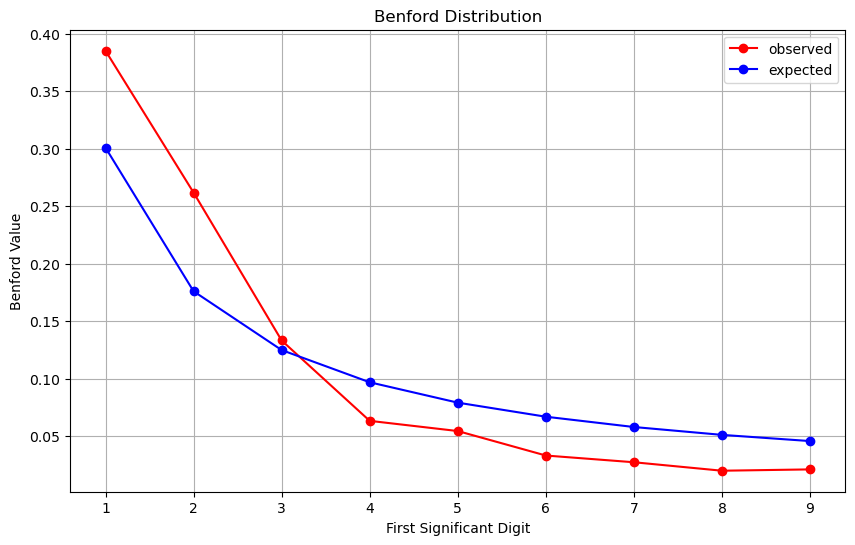

In [104]:
# Define the function to calculate flow size difference
def calculate_flow_size_difference(flow_sizes):
    flow_size_difference = []
    for i in range(1, len(flow_sizes)):
        difference = abs(flow_sizes[i] - flow_sizes[i-1])
        flow_size_difference.append(difference)
    return flow_size_difference

# Calculate flow size difference for a specific column
flow_size_diff = calculate_flow_size_difference(np.array(normal_dataset['duration']))

# Function to extract first significant digit and handle zero values
def extract_first_significant_digit(flow_size_diff):
    first_digits = []
    for diff in flow_size_diff:
        if diff == 0:
            continue
        first_digit = int(str(diff)[0])
        first_digits.append(first_digit)
    return first_digits

# Extract first significant digit and handle zero values
first_digits = extract_first_significant_digit(flow_size_diff)

# Calculate frequency distribution of first significant digits
first_digit_counts = np.bincount(first_digits)[1:]

# Calculate percentage distribution
percentage_distribution = (first_digit_counts / len(first_digits))

# Define the function to calculate Inverse-Benford distribution
def benford_distribution(d):
    return math.log10(1 + 1 / d)

# Calculate Inverse-Benford distribution for each digit
benford_distribution_values = [benford_distribution(d) for d in range(1, 10)]

# Plot the Inverse-Benford distribution
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), percentage_distribution, marker='o', color='red', label='observed')
plt.plot(range(1, 10), benford_distribution_values, marker='o', color='blue', label='expected')
plt.title("Benford Distribution")
plt.xlabel("First Significant Digit")
plt.ylabel("Benford Value")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()


In [106]:
# Calculate χ² divergence
chi_square_divergence = np.sum((percentage_distribution - benford_distribution_values)**2 / benford_distribution_values)

print("χ² Divergence between observed and expected distributions:", chi_square_divergence)

χ² Divergence between observed and expected distributions: 0.15087381105947323


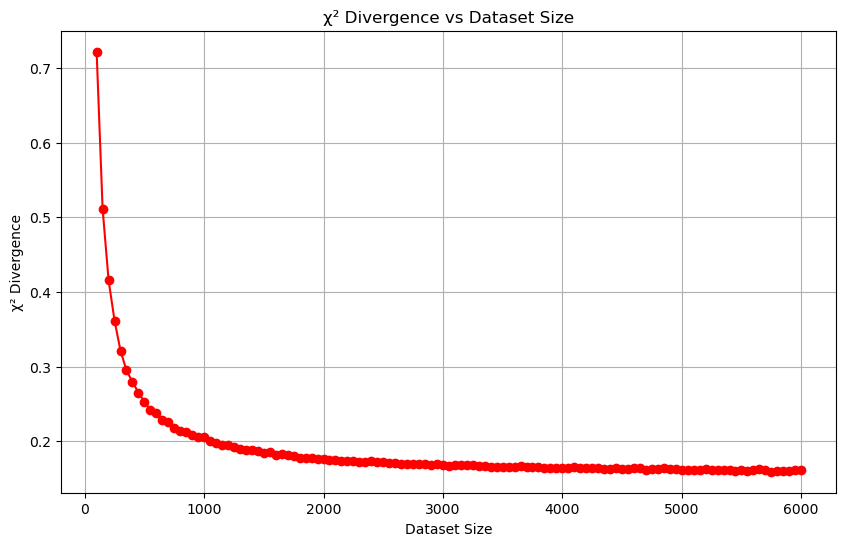

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to calculate flow size difference
def calculate_flow_size_difference(flow_sizes):
    flow_size_difference = []
    for i in range(1, len(flow_sizes)):
        difference = abs(flow_sizes[i] - flow_sizes[i-1])
        flow_size_difference.append(difference)
    return flow_size_difference

# Function to extract first significant digit and handle zero values
def extract_first_significant_digit(flow_size_diff):
    first_digits = []
    for diff in flow_size_diff:
        if diff == 0:
            continue
        first_digit = int(str(diff)[0])
        first_digits.append(first_digit)
    return first_digits

# Define the function to calculate χ² divergence
def calculate_chi_square_divergence(observed, expected):
    return np.sum((observed - expected)**2 / expected)

# Initialize lists to store dataset sizes and χ² values
window_sizes = range(100, 6001, 50)
chi_square_values = []

# Define expected distribution for Benford's law
benford_distribution_values = [1 / d for d in range(1, 10)]

attributes = ['duration']
#               , 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

# Loop through dataset sizes and calculate χ² values
for window_size in window_sizes:
    
    if window_size == 0:
        continue
    
    # Define an empty list to store chi-square values for all attributes
    all_chi_square_values = []
    step_size = window_size//2
    
    # Iterate over all attributes
    for start_index in range(0, len(normal_dataset), step_size):
        
        end_index = start_index + window_size
        if end_index > len(normal_dataset):
            break 
        
        # Sample a subset of the dataset for the current attribute
        sampled_dataset = normal_dataset[attribute][start_index:end_index]

        # Calculate flow size difference for the sampled dataset
        flow_size_diff = calculate_flow_size_difference(np.array(sampled_dataset))

        # Extract first significant digit and handle zero values
        first_digits = extract_first_significant_digit(flow_size_diff)

        # Calculate frequency distribution of first significant digits
        first_digit_counts = np.bincount(first_digits, minlength=10)[1:]

        # Normalize the observed distribution
        observed_distribution = first_digit_counts / np.sum(first_digit_counts)

        # Calculate expected distribution (Benford's distribution)
        benford_distribution_values = [benford_distribution(d) for d in range(1, 10)]

        # Calculate χ² divergence
        chi_square_divergence = calculate_chi_square_divergence(observed_distribution, benford_distribution_values)

        # Append chi-square divergence to the list for all attributes
        all_chi_square_values.append(chi_square_divergence)

    # Sum up the chi-square divergences for all attributes
    total_chi_square = sum(all_chi_square_values)/len(all_chi_square_values)
    chi_square_values.append(total_chi_square)

# Plot the χ² values against dataset sizes
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, chi_square_values, marker='o', color='red')
plt.title("χ² Divergence vs Dataset Size")
plt.xlabel("Dataset Size")
plt.ylabel("χ² Divergence")
plt.grid(True)
plt.show()


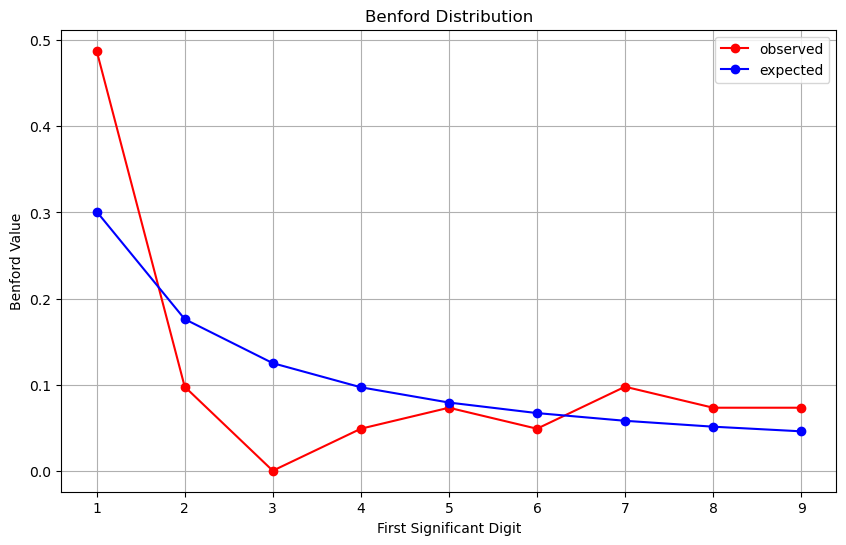

In [153]:
# Define the function to calculate flow size difference
def calculate_flow_size_difference(flow_sizes):
    flow_size_difference = []
    for i in range(1, len(flow_sizes)):
        difference = abs(flow_sizes[i] - flow_sizes[i-1])
        flow_size_difference.append(difference)
    return flow_size_difference

# Calculate flow size difference for a specific column
flow_size_diff = calculate_flow_size_difference(np.array(malicious_dataset[malicious_dataset['attack'] =='Dos']['duration']))

# Function to extract first significant digit and handle zero values
def extract_first_significant_digit(flow_size_diff):
    first_digits = []
    for diff in flow_size_diff:
        if diff == 0:
            continue
        first_digit = int(str(diff)[0])
        first_digits.append(first_digit)
    return first_digits

# Extract first significant digit and handle zero values
first_digits = extract_first_significant_digit(flow_size_diff)

# Calculate frequency distribution of first significant digits
first_digit_counts = np.bincount(first_digits)[1:]

# Calculate percentage distribution
percentage_distribution = (first_digit_counts / len(first_digits))

# Define the function to calculate Inverse-Benford distribution
def benford_distribution(d):
    return math.log10(1 + 1 / d)

# Calculate Inverse-Benford distribution for each digit
benford_distribution_values = [benford_distribution(d) for d in range(1, 10)]

# Plot the Inverse-Benford distribution
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), percentage_distribution, marker='o', color='red', label='observed')
plt.plot(range(1, 10), benford_distribution_values, marker='o', color='blue', label='expected')
plt.title("Benford Distribution")
plt.xlabel("First Significant Digit")
plt.ylabel("Benford Value")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()



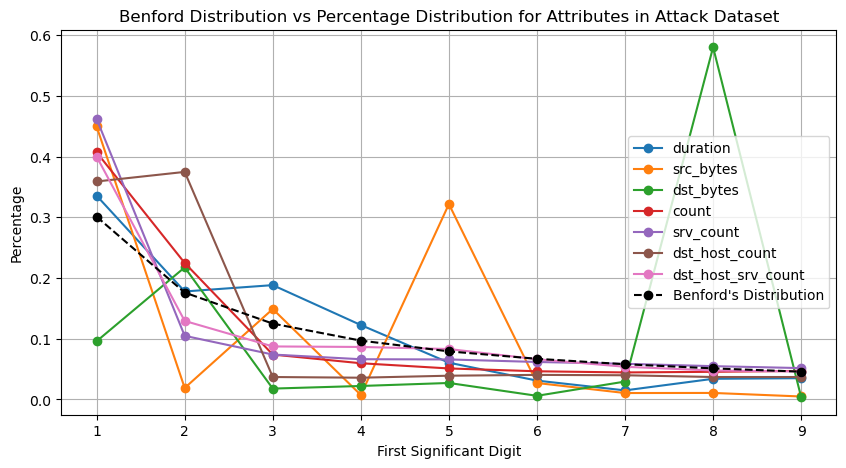

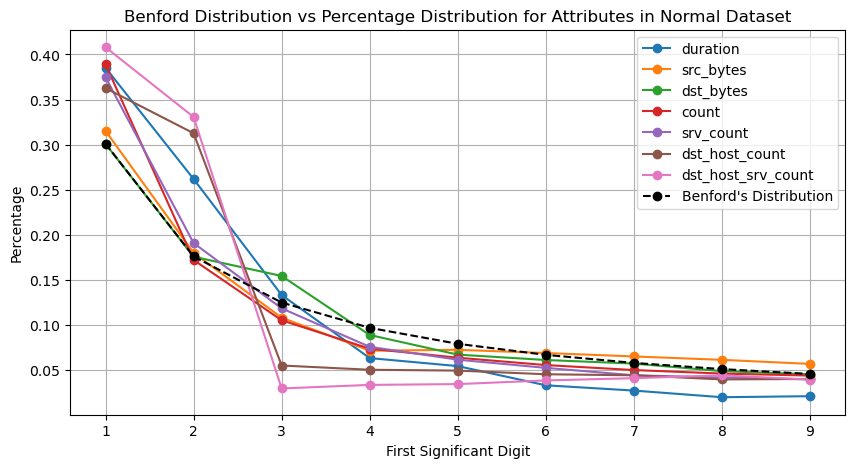

In [154]:
# Function to calculate percentage distribution
def calculate_percentage_distribution(flow_size_diff):
    first_digits = extract_first_significant_digit(flow_size_diff)
    first_digit_counts = np.bincount(first_digits)[1:]
    return first_digit_counts / len(first_digits)

# Attributes used in the code
attributes = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

plt.figure(figsize=(10, 5))

for i, attribute in enumerate(attributes):
    data_attack = malicious_dataset[attribute]
    flow_size_diff = calculate_flow_size_difference(np.array(data_attack))
    percentage_distribution = calculate_percentage_distribution(flow_size_diff)

    plt.plot(range(1, 10), percentage_distribution, marker='o', label=f'{attribute}')

plt.plot(range(1, 10), benford_distribution_values, marker='o', color='black', linestyle='--', label="Benford's Distribution")
plt.title("Benford Distribution vs Percentage Distribution for Attributes in Attack Dataset")
plt.xlabel("First Significant Digit")
plt.ylabel("Percentage")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

for i, attribute in enumerate(attributes):
    data_normal = normal_dataset[attribute]
    flow_size_diff = calculate_flow_size_difference(np.array(data_normal))
    percentage_distribution = calculate_percentage_distribution(flow_size_diff)

    plt.plot(range(1, 10), percentage_distribution, marker='o', label=f'{attribute}')

plt.plot(range(1, 10), benford_distribution_values, marker='o', color='black', linestyle='--', label="Benford's Distribution")
plt.title("Benford Distribution vs Percentage Distribution for Attributes in Normal Dataset")
plt.xlabel("First Significant Digit")
plt.ylabel("Percentage")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()


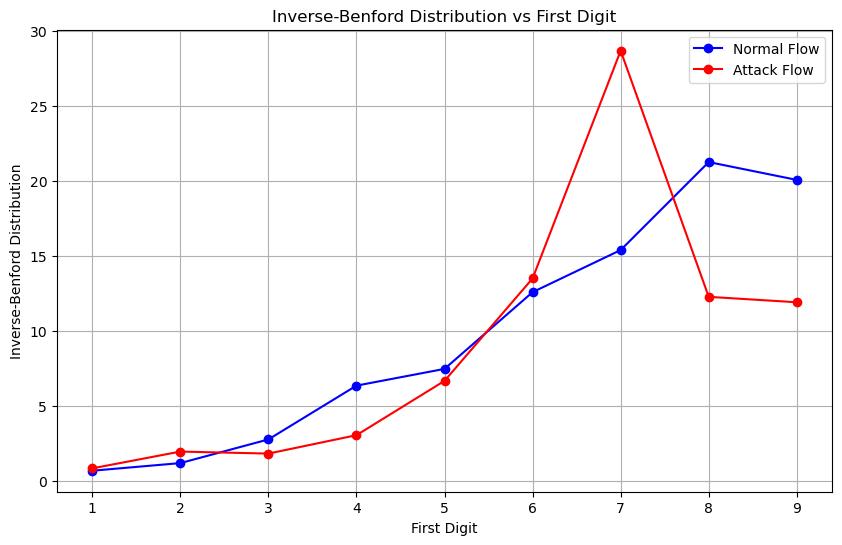

In [97]:
# Define the function to calculate flow size difference
def calculate_flow_size_difference(flow_sizes):
    flow_size_difference = []
    for i in range(1, len(flow_sizes)):
        difference = abs(flow_sizes[i] - flow_sizes[i-1])
        flow_size_difference.append(difference)
    return flow_size_difference

# Calculate flow size difference for normal and attack flows
flow_size_diff_normal = calculate_flow_size_difference(np.array(normal_dataset['duration']))
flow_size_diff_attack = calculate_flow_size_difference(np.array(malicious_dataset['duration']))

# Function to extract first significant digit and handle zero values
def extract_first_significant_digit(flow_size_diff):
    first_digits = []
    for diff in flow_size_diff:
        if diff == 0:
            continue
        first_digit = int(str(diff)[0])
        first_digits.append(first_digit)
    return first_digits

# Extract first significant digit and handle zero values for normal and attack flows
first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)
first_digits_attack = extract_first_significant_digit(flow_size_diff_attack)

# Calculate frequency distribution of first significant digits for normal and attack flows
first_digit_counts_normal = np.bincount(first_digits_normal)[1:]
first_digit_counts_attack = np.bincount(first_digits_attack)[1:]

# Pad the attack flow count with zeros if needed to ensure both arrays have the same length
if len(first_digit_counts_attack) < 9:
    first_digit_counts_attack = np.pad(first_digit_counts_attack, (0, 9 - len(first_digit_counts_attack)), 'constant')

# Calculate percentage distribution for normal and attack flows
percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))
percentage_distribution_attack = (first_digit_counts_attack / len(first_digits_attack))

# Define the function to calculate Inverse-Benford distribution
def inverse_benford_distribution(frequency):
    return 1 / (10**(frequency) - 1)

# Calculate Inverse-Benford distribution for each digit
inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]
inverse_benford_distribution_values_attack = [inverse_benford_distribution(f) for f in percentage_distribution_attack]

# Plot the Inverse-Benford distribution
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inverse_benford_distribution_values_normal, marker='o', color='blue', label='Normal Flow')
plt.plot(range(1, 10), inverse_benford_distribution_values_attack, marker='o', color='red', label='Attack Flow')
plt.title("Inverse-Benford Distribution vs First Digit")
plt.xlabel("First Digit")
plt.ylabel("Inverse-Benford Distribution")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()

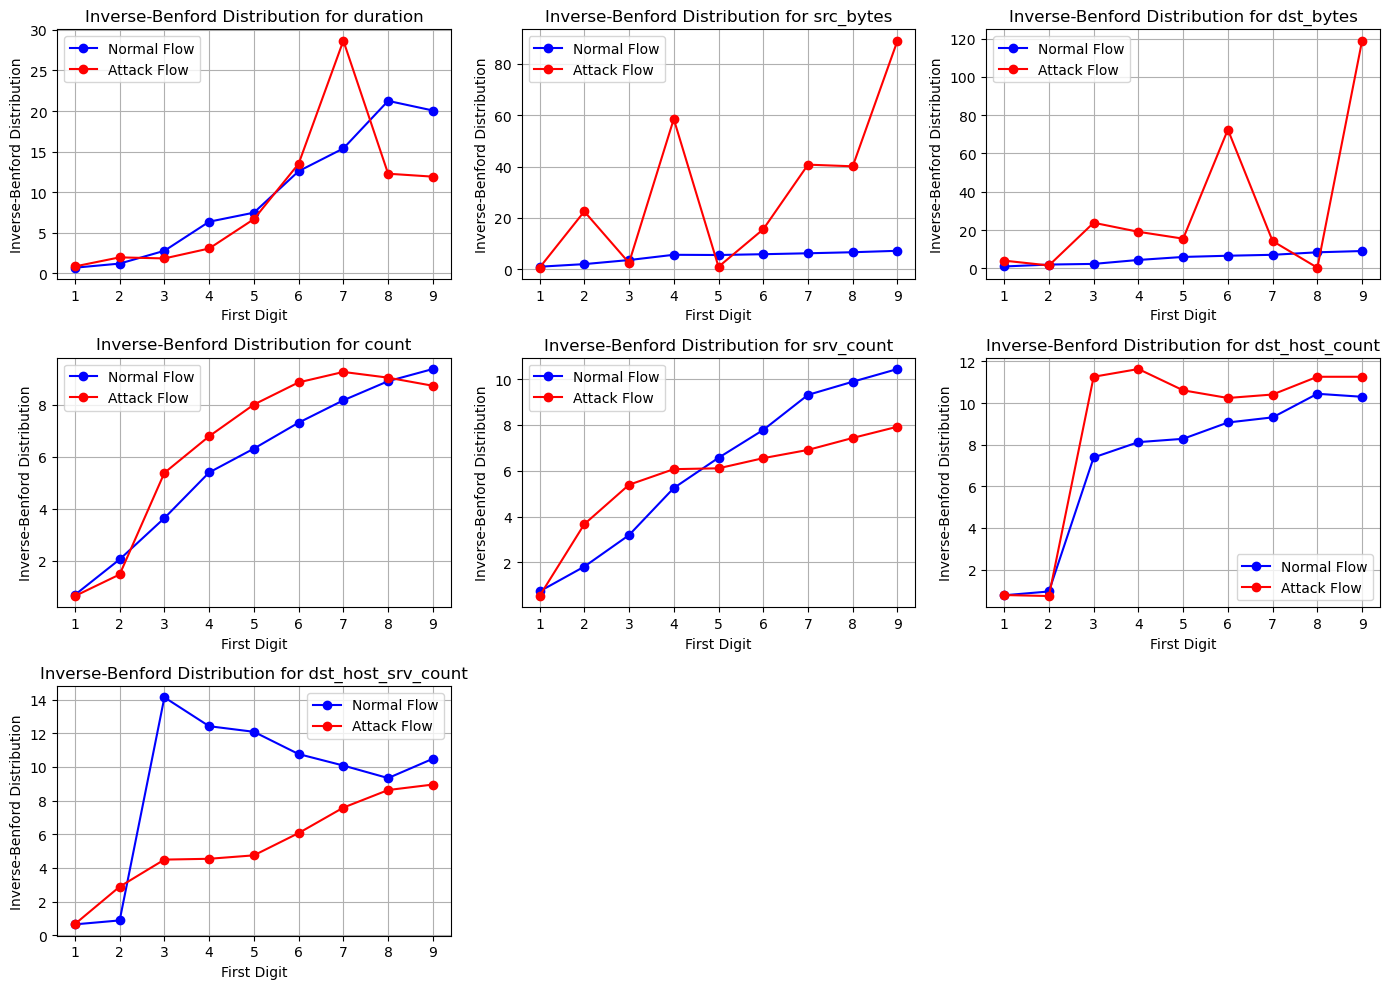

In [101]:
def calculate_inverse_benford_distribution(data_normal, data_attack):
    # Calculate flow size difference for normal and attack flows
    flow_size_diff_normal = calculate_flow_size_difference(np.array(data_normal))
    flow_size_diff_attack = calculate_flow_size_difference(np.array(data_attack))

    # Extract first significant digit and handle zero values for normal and attack flows
    first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)
    first_digits_attack = extract_first_significant_digit(flow_size_diff_attack)

    # Calculate frequency distribution of first significant digits for normal and attack flows
    first_digit_counts_normal = np.bincount(first_digits_normal)[1:]
    first_digit_counts_attack = np.bincount(first_digits_attack)[1:]

    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_attack) < 9:
        first_digit_counts_attack = np.pad(first_digit_counts_attack, (0, 9 - len(first_digit_counts_attack)), 'constant')

    # Calculate percentage distribution for normal and attack flows
    percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))
    percentage_distribution_attack = (first_digit_counts_attack / len(first_digits_attack))

    # Calculate Inverse-Benford distribution for each digit
    inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]
    inverse_benford_distribution_values_attack = [inverse_benford_distribution(f) for f in percentage_distribution_attack]

    return inverse_benford_distribution_values_normal, inverse_benford_distribution_values_attack

# Calculate Inverse-Benford distribution for all attributes
attributes = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

plt.figure(figsize=(14, 10))

for i, attribute in enumerate(attributes):
    data_normal = normal_dataset[attribute]
    data_attack = malicious_dataset[attribute]
    
    inverse_benford_distribution_values_normal, inverse_benford_distribution_values_attack = calculate_inverse_benford_distribution(data_normal, data_attack)
    
    plt.subplot(3, 3, i+1)
    plt.plot(range(1, 10), inverse_benford_distribution_values_normal, marker='o', color='blue', label='Normal Flow')
    plt.plot(range(1, 10), inverse_benford_distribution_values_attack, marker='o', color='red', label='Attack Flow')
    plt.title(f"Inverse-Benford Distribution for {attribute}")
    plt.xlabel("First Digit")
    plt.ylabel("Inverse-Benford Distribution")
    plt.xticks(range(1, 10))
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [103]:
# Perform linear regression, calculate error metrics, and classify flows for all attributes
attributes = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

threshold_mae = 0.1
threshold_mse = 0.05
threshold_rmse = 0.07

for attribute in attributes:
    data_normal = normal_dataset[attribute]
    data_attack = malicious_dataset[attribute]
    
    inverse_benford_distribution_values_normal, inverse_benford_distribution_values_attack = calculate_inverse_benford_distribution(data_normal, data_attack)
    
    # Perform linear regression
    X = np.array(range(1, 10)).reshape(-1, 1)
    regressor = LinearRegression()
    regressor.fit(X, inverse_benford_distribution_values_normal)
    y_pred_normal = regressor.predict(X)

    # Calculate error metrics for normal flow
    error_metrics_normal = {
        'MAE': np.mean(np.abs(inverse_benford_distribution_values_normal - y_pred_normal)),
        'MSE': np.mean((inverse_benford_distribution_values_normal - y_pred_normal)**2),
        'RMSE': np.sqrt(np.mean((inverse_benford_distribution_values_normal - y_pred_normal)**2))
    }
    
    # Print error metrics for normal flow
    print(f"\nError Metrics for Normal Flow - {attribute}:")
    for metric, value in error_metrics_normal.items():
        print(f"{metric}: {value}")

    # Classify normal flows based on error metrics
    if (error_metrics_normal['MAE'] < threshold_mae and
        error_metrics_normal['MSE'] < threshold_mse and
        error_metrics_normal['RMSE'] < threshold_rmse):
        print("Normal Flow")

#     # Calculate error metrics for attack flow
#     regressor.fit(X, inverse_benford_distribution_values_attack)
#    y_pred_attack = regressor.predict()
    
    error_metrics_attack = {
        'MAE': np.mean(np.abs(inverse_benford_distribution_values_attack - y_pred_normal)),
        'MSE': np.mean((inverse_benford_distribution_values_attack - y_pred_normal)**2),
        'RMSE': np.sqrt(np.mean((inverse_benford_distribution_values_attack - y_pred_normal)**2))
    }
    
    # Print error metrics for attack flow
    print(f"\nError Metrics for Attack Flow - {attribute}:")
    for metric, value in error_metrics_attack.items():
        print(f"{metric}: {value}")

    # Classify attack flows based on error metrics
    if (error_metrics_attack['MAE'] > threshold_mae or
        error_metrics_attack['MSE'] > threshold_mse or
        error_metrics_attack['RMSE'] > threshold_rmse):
        print("Attack Flow")



Error Metrics for Normal Flow - duration:
MAE: 1.16991371581637
MSE: 2.489502510072805
RMSE: 1.5778157402158228

Error Metrics for Attack Flow - duration:
MAE: 4.6137771524156586
MSE: 36.7933783980091
RMSE: 6.065754561306375
Attack Flow

Error Metrics for Normal Flow - src_bytes:
MAE: 0.6001344255349137
MSE: 0.5265261652169929
RMSE: 0.7256212270992304

Error Metrics for Attack Flow - src_bytes:
MAE: 26.58863472968579
MSE: 1374.95187097904
RMSE: 37.08034345821301
Attack Flow

Error Metrics for Normal Flow - dst_bytes:
MAE: 0.30710406450915767
MSE: 0.16882263151184365
RMSE: 0.4108803128793635

Error Metrics for Attack Flow - dst_bytes:
MAE: 26.686023586184174
MSE: 1916.44775541147
RMSE: 43.77725157443612
Attack Flow

Error Metrics for Normal Flow - count:
MAE: 0.450327222585105
MSE: 0.26256917746603475
RMSE: 0.5124150441449146

Error Metrics for Attack Flow - count:
MAE: 1.4071580360331266
MSE: 2.4631488442469482
RMSE: 1.5694422079984176
Attack Flow

Error Metrics for Normal Flow - srv_

In [133]:
def calculate_inverse_benford_distribution(data_normal):
    # Calculate flow size difference for normal and attack flows
    flow_size_diff_normal = calculate_flow_size_difference(np.array(data_normal))

    # Extract first significant digit and handle zero values for normal and attack flows
    first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)

    # Calculate frequency distribution of first significant digits for normal and attack flows
    first_digit_counts_normal = np.bincount(first_digits_normal)[1:]

    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_normal) < 9:
        first_digit_counts_normal = np.pad(first_digit_counts_normal, (0, 9 - len(first_digit_counts_normal)), 'constant')

    # Calculate percentage distribution for normal and attack flows
    percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))

    # Calculate Inverse-Benford distribution for each digit
    inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]

    return inverse_benford_distribution_values_normal

In [136]:
from sklearn.linear_model import LinearRegression

# Train the attribute using the 100% normal dataset
def train_attribute(normal_dataset, attribute):
    X_train = np.array(range(1, 10)).reshape(-1, 1)
    y_train = calculate_inverse_benford_distribution(normal_dataset[attribute])
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    return regressor

# Function to generate datasets with different percentages of normal and attack traffic
def generate_datasets(normal_dataset, malicious_dataset, attribute, normal_percentage):
    normal_samples = int(3000 * normal_percentage)
    attack_samples = 3000 - normal_samples
    
    normal_data = normal_dataset.sample(n=normal_samples, replace=False)
    attack_data = malicious_dataset.sample(n=attack_samples, replace=False)
    
    return pd.concat([normal_data, attack_data])

# Perform linear regression, calculate error metrics, and classify flows for all attributes
attributes = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']
threshold_mae = 0.1
threshold_mse = 0.05
threshold_rmse = 0.07

# Dictionary to store trained models
trained_models = {}

# Train the models with the complete normal dataset
for attribute in attributes:
    trained_models[attribute] = train_attribute(normal_dataset, attribute)

# Evaluate datasets with different percentages of normal and attack traffic
for normal_percentage in [1.0, 0.7, 0.5, 0.3]:
    print(f"\nNormal Percentage: {normal_percentage * 100}%")
    for attribute in attributes:
        trained_attribute = trained_models[attribute]
        dataset = generate_datasets(normal_dataset, malicious_dataset, attribute, normal_percentage)
        
        # Calculate inverse Benford distribution for the generated dataset
        X_test = np.array(range(1, 10)).reshape(-1, 1)
        y_test = calculate_inverse_benford_distribution(dataset[attribute])
        
        # Predict using the trained attribute
        y_pred = trained_attribute.predict(X_test)
        
        # Calculate error metrics
        error_metrics = {
            'MAE': np.mean(np.abs(y_test - y_pred)),
            'MSE': np.mean((y_test - y_pred)**2),
            'RMSE': np.sqrt(np.mean((y_test - y_pred)**2))
        }
        
        # Print error metrics
        print(f"\nError Metrics for {attribute} Attribute:")
        for metric, value in error_metrics.items():
            print(f"{metric}: {value}")
        
        # Classify flows based on error metrics
        if (error_metrics['MAE'] < threshold_mae and
            error_metrics['MSE'] < threshold_mse and
            error_metrics['RMSE'] < threshold_rmse):
            print("Classification: Normal Flow")
        else:
            print("Classification: Attack Flow")



Normal Percentage: 100.0%

Error Metrics for duration Attribute:
MAE: 1.6247812379835505
MSE: 7.579474093745146
RMSE: 2.7530844690537823
Classification: Attack Flow

Error Metrics for src_bytes Attribute:
MAE: 0.7893561013077051
MSE: 0.8611100806781846
RMSE: 0.92796017192452
Classification: Attack Flow

Error Metrics for dst_bytes Attribute:
MAE: 0.4777659232151577
MSE: 0.3365776261088223
RMSE: 0.5801531057478037
Classification: Attack Flow

Error Metrics for count Attribute:
MAE: 0.5741579870803575
MSE: 0.5532026763099499
RMSE: 0.7437759584108308
Classification: Attack Flow

Error Metrics for srv_count Attribute:
MAE: 0.22626323113564586
MSE: 0.12661540297587814
RMSE: 0.35583058184461624
Classification: Attack Flow

Error Metrics for dst_host_count Attribute:
MAE: 1.8974303729776263
MSE: 4.557077903407587
RMSE: 2.1347313422085663
Classification: Attack Flow

Error Metrics for dst_host_srv_count Attribute:
MAE: 3.441621976242871
MSE: 18.493867672177387
RMSE: 4.3004497058072175
Classif

In [148]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Train the attribute using the 100% normal dataset
def train_attribute(normal_dataset, attribute):
    X_train = np.array(range(1, 10)).reshape(-1, 1)
    y_train = calculate_inverse_benford_distribution(normal_dataset[attribute].sample(n=5000, replace=False))
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    return regressor

# Function to generate datasets with different percentages of normal and attack traffic
def generate_datasets(normal_dataset, malicious_dataset, attribute, normal_percentage):
    normal_samples = int(5000 * normal_percentage)
    attack_samples = 5000 - normal_samples
    
    normal_data = normal_dataset.sample(n=normal_samples, replace=False)
    attack_data = malicious_dataset.sample(n=attack_samples, replace=False)
    
    return pd.concat([normal_data, attack_data])

# Perform linear regression, calculate error metrics, and classify flows for all attributes
attributes = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']
threshold_mae = 0.1
threshold_mse = 0.05
threshold_rmse = 0.07

# Create an empty DataFrame to store error metrics
error_metrics_df = pd.DataFrame(columns=['Attribute', 'Normal Percentage', 'MAE', 'MSE', 'RMSE'])

# Dictionary to store trained models
trained_models = {}

# Train the models with the complete normal dataset
for attribute in attributes:
    trained_models[attribute] = train_attribute(normal_dataset, attribute)

# Evaluate datasets with different percentages of normal and attack traffic
for normal_percentage in [1.0, 0.7, 0.5, 0.3]:
    error_metrics_df_ratio = pd.DataFrame(columns=['Attribute', 'Normal Percentage', 'MAE', 'MSE', 'RMSE'])
    for attribute in attributes:
        trained_attribute = trained_models[attribute]
        dataset = generate_datasets(normal_dataset, malicious_dataset, attribute, normal_percentage)
        
        # Calculate inverse Benford distribution for the generated dataset
        X_test = np.array(range(1, 10)).reshape(-1, 1)
        y_test = calculate_inverse_benford_distribution(dataset[attribute])
        
        # Predict using the trained attribute
        y_pred = trained_attribute.predict(X_test)
        
        # Calculate error metrics
        error_metrics = {
            'MAE': np.mean(np.abs(y_test - y_pred)),
            'MSE': np.mean((y_test - y_pred)**2),
            'RMSE': np.sqrt(np.mean((y_test - y_pred)**2))
        }
        
        # Classify flows based on error metrics
        classification = "Normal Flow" if all(error_metrics[metric] < threshold for metric, threshold in zip(['MAE', 'MSE', 'RMSE'], [threshold_mae, threshold_mse, threshold_rmse])) else "Attack Flow"
        
        # Append error metrics to DataFrame
        error_metrics_df_ratio = pd.concat([error_metrics_df_ratio, pd.DataFrame([{'Attribute': attribute,
                                                                                    'Normal Percentage': f"{int(normal_percentage * 100)}%",
                                                                                    'MAE': error_metrics['MAE'],
                                                                                    'MSE': error_metrics['MSE'],
                                                                                    'RMSE': error_metrics['RMSE']}])])
    print(f"\nError Metrics for Normal Percentage: {int(normal_percentage * 100)}%")
    print(error_metrics_df_ratio)



Error Metrics for Normal Percentage: 100%
            Attribute Normal Percentage       MAE        MSE      RMSE
0            duration              100%  2.142626   8.072729  2.841255
0           src_bytes              100%  0.948526   1.235867  1.111696
0           dst_bytes              100%  0.386107   0.231218  0.480851
0               count              100%  0.425136   0.238922  0.488797
0           srv_count              100%  0.357250   0.199614  0.446782
0      dst_host_count              100%  1.811822   4.226560  2.055860
0  dst_host_srv_count              100%  2.924172  13.482608  3.671867

Error Metrics for Normal Percentage: 70%
            Attribute Normal Percentage       MAE         MSE       RMSE
0            duration               70%  6.437054  141.756383  11.906149
0           src_bytes               70%  0.700836    0.788911   0.888207
0           dst_bytes               70%  0.608628    0.573928   0.757580
0               count               70%  0.684172    0.